In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import torch
from itertools import product
torch.set_printoptions(precision=2,sci_mode=False, linewidth=200)

In [2]:
# Returns the features for our XOR dataset
def xor_mixture_of_Gaussians(n_points, n_features, mu, nu, sig_sq):
    X = torch.zeros((n_points, n_features))
    y = torch.zeros(n_points)
    for i in range(n_points):
        mean = torch.randn(n_features)
        # Decide class and cluster.
        y[i] = 0 if i < n_points//2 else 1
        if y[i] == 0 and i < n_points//4:
            mean = mu
        elif y[i] == 0 and i < n_points//2:
            mean = -mu
        elif i < 3*n_points//4:
            mean = nu
        else:
            mean = -nu
            
        if sig_sq > 0:
            cov = torch.eye(n_features) * sig_sq
            distr = torch.distributions.MultivariateNormal(mean, cov)
            X[i] = distr.sample()
        else:
            X[i] = mean
            
    return X, y

## Create dataset

In [44]:
# Dimensions
n_points = 1000
n_features = 2
print("n_points:", n_points)
print("n_features:", n_features)

# Set means and variance.
mean_scale = 5.0
mu = torch.zeros(n_features)
mu[0] = mean_scale
nu = torch.zeros(n_features)
nu[1] = mean_scale
sig_sq = 5/np.sqrt(n_features)

X, y = xor_mixture_of_Gaussians(n_points, n_features, mu, nu, sig_sq)

n_points: 1000
n_features: 2


## Ansatz

In [45]:
# Output returned by the ansatz on some data matrix X.
def ansatz(X, mu, nu):
    w1 = torch.stack([mu, -mu, nu, -nu]).t()
    w2 = torch.tensor([[-1., -1., 1., 1.]]).t()
    out = (torch.relu(X@w1))@w2
    out = torch.sigmoid(out)
    return torch.squeeze(out, dim=1), w1, w2

yhat = ansatz(X, mu, nu)

## Plots

In [46]:
def visualize_features(X, y, filename, lims=None, print_means=True, figsize=(10,10)):
    colors = ['#b4271f', '#1f77b4']
    mkr = ['o', 'o']
    sz = [20, 20]
    fig = plt.figure(figsize=figsize, facecolor=[1,1,1])
    ax = plt.axes()
    # plt.axis('off')
    feats = {}
    feats[0] = []
    feats[1] = []
    
    if lims is not None:
        plt.xlim([lims[0][0], lims[0][1]])
        plt.ylim([lims[1][0], lims[1][1]])
    
    for (idx, label) in enumerate(y):
        if label == 0:
            feats[0].append(X[idx])
        else:
            feats[1].append(X[idx])
    for c in range(2):
        X_coords = [f[0] for f in feats[c]]
        Y_coords = [f[1] for f in feats[c]]
        ax.scatter(X_coords, Y_coords, color=colors[c], marker=mkr[c], s=sz[c])
        
    if print_means:
        t = plt.text(mu[0], mu[1], r'$\mu$', fontsize=30, weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
        t = plt.text(-mu[0], -mu[1], r'$-\mu$', fontsize=30, weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
        t = plt.text(nu[0], nu[1], r'$\nu$', fontsize=30, weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
        t = plt.text(-nu[0], -nu[1], r'$-\nu$', fontsize=30, weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    
    fig.savefig('figures/' + filename, dpi=400, bbox_inches='tight')

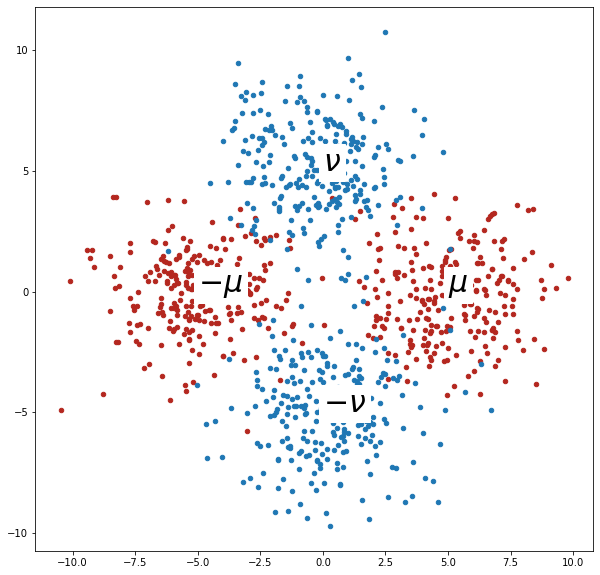

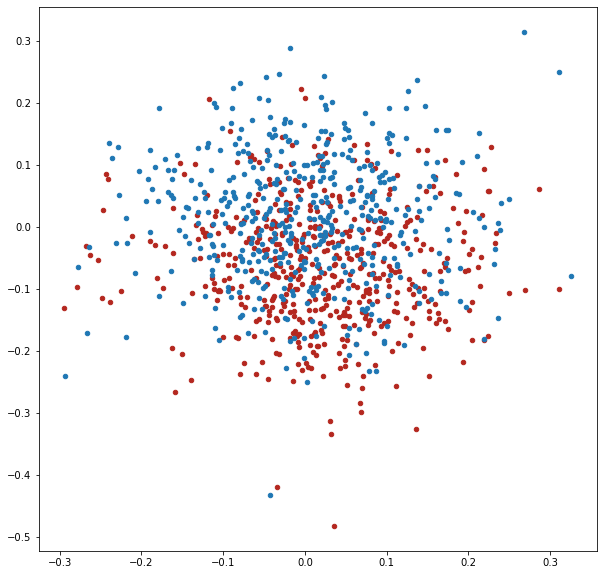

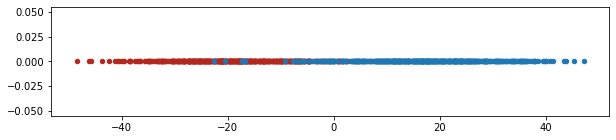

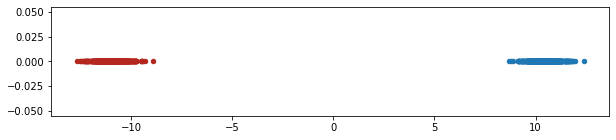

In [48]:
# THE FOLLOWING WORKS ONLY FOR n_features = 2.
lim = 12
# lims = [[-lim, lim], [-lim, lim]]
lims = None
probs = [[.8, .2], [.2, .8]]
y1 = torch.sum(y).int()
y0 = n_points - y1
class_sizes = [y0.item(), y1.item()]
g = nx.stochastic_block_model(class_sizes, probs, selfloops=True)
A = torch.tensor(nx.adjacency_matrix(g).todense())
deg_inv = torch.diag(1./torch.sum(A, dim=0))

# Conv in layer 1.
Xt = X.double()
Xt = deg_inv@A@Xt
visualize_features(X, y, 'orig_data.pdf', lims=lims)
visualize_features(Xt, y, 'conv_1.pdf', lims=lims, print_means=False)

# Conv in layer 2.
w1 = torch.stack([mu, -mu, nu, -nu]).t()
w2 = torch.tensor([[-1., -1., 1., 1.]]).t()
Xl = (torch.relu(X@w1))@w2
Xl = torch.stack((torch.squeeze(Xl), torch.zeros(n_points)), dim=1)
Xt = Xl.double()
Xt = deg_inv@A@Xt
visualize_features(Xl, y, 'transformed_data.pdf', lims=lims, print_means=False, figsize=(10,2))
# lim = 30
# lims = [[-lim, lim], [-lim, lim]]
visualize_features(Xt, y, 'conv_2.pdf', lims=lims, print_means=False, figsize=(10,2))